In [ ]:
! pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time
import random # for torch seed
import os # for torch seed
import cv2
import numpy as np

from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, AdamW, RMSprop # optmizers
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau # Learning rate schedulers

import timm #models pretrained

from sklearn.model_selection import train_test_split

from PIL import Image

import matplotlib.pyplot as plt

import zipfile

import torchvision.transforms as T
from torchvision.utils import make_grid
import torchvision.models as models

# Przygotowanie Datasetu

Pobranie DataSetu

In [ ]:
! ls ~/.kaggle

kaggle.json


In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
#! kaggle competitions download <name-of-competition>
#! kaggle datasets download <name-of-dataset>

In [ ]:
! kaggle competitions download dogs-vs-cats

dogs-vs-cats.zip: Skipping, found more recently modified local copy (use --force to force download)


Ekstrakcja DataSetu

In [ ]:
### Extracting whole dataset
ZIP_DATA_PATH = "./dogs-vs-cats.zip"

zipfile.ZipFile(ZIP_DATA_PATH, mode="r").extractall()

In [ ]:
### Extracting train and test dataset
ZIP_TRAIN_DATA_PATH = "./train.zip"
ZIP_TEST_DATA_PATH = "./test1.zip"

zipfile.ZipFile(ZIP_TRAIN_DATA_PATH, mode="r").extractall()
zipfile.ZipFile(ZIP_TEST_DATA_PATH, mode="r").extractall()

TRAIN_PATH = './train/'
TEST_PATH = './test1/'

Parametry Input do Modelu

In [ ]:
WIDTH = 256
HEIGHT = 192

Transformacje zbiorów Train i Val

In [ ]:
def get_train_transform():
    return T.Compose([
        T.CenterCrop((HEIGHT,WIDTH)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])


def get_test_transform():
    return T.Compose([
        T.CenterCrop((HEIGHT,WIDTH)),
        #T.Resize((HEIGHT,WIDTH)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

In [ ]:
class CatDogDataset(Dataset):

    def __init__(self, imgs, directory, class_to_int, device, mode="train", transforms=None):

        super().__init__()
        self.imgs = imgs
        self.directory = directory
        self.class_to_int = class_to_int
        self.mode = mode
        self.transforms = transforms
        self.device = device

    def __getitem__(self, idx):

        ### Taking name from names list
        image_name = self.imgs[idx]

        ### Reading, converting and normalizing image
        img = cv2.imread(self.directory + image_name, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img /= 255.
        img = Image.open(self.directory + image_name)

        if self.mode == "train" or self.mode == "val":

            ### Preparing class label
            label = self.class_to_int[image_name.split(".")[0]]
            label = torch.tensor(label, dtype=torch.int64)

            ### Apply Transforms on image
            img = self.transforms(img)

            return img, label

        elif self.mode == "test":

            ### Apply Transforms on image
            img = self.transforms(img)

            return img

    def __len__(self):
        return len(self.imgs)

#Reading all names in directory
train_imgs = os.listdir(TRAIN_PATH)
test_imgs = os.listdir(TEST_PATH)

### Datasets creating
class_to_int = {"dog":0, "cat":1}
train_dataset = CatDogDataset(train_imgs, TRAIN_PATH, class_to_int, device, mode="train", transforms = get_train_transform())
test_dataset = CatDogDataset(test_imgs, TEST_PATH, class_to_int, device,  mode="test", transforms = get_test_transform())

train_data_loader = DataLoader(
    dataset=train_dataset,
    num_workers=1,
    batch_size=1,
    shuffle=True
)

test_data_loader = DataLoader(
    dataset=test_dataset,
    num_workers=1,
    batch_size=1,
    shuffle=True
)

In [ ]:
%%script echo skipping
### Getting images from train DataLoader -> We've got labels and 3 channels od image
imgs = next(iter(train_data_loader))
img1 = imgs[0][0]
plt.imshow(img1.permute(1,2,0))
plt.show()
print(int(imgs[1]))

skipping


In [ ]:
%%script echo skipping
### Showing image from test dataloader we do not have labels here
img1 = next(iter(test_data_loader))
img1.shape
plt.imshow(img1[0].permute(1, 2, 0))


skipping


In [ ]:
class HRNetEmbedding(nn.Module):
      def __init__(self):
        super().__init__()

        #init a pretrained HRNet
        self.cnn = timm.create_model('hrnet_w18', pretrained=True)
       
        layers = list(self.cnn.children())[:]
        #num_features = layers[-1].out_features
        #print(num_features)

      def forward(self, x):
        
        #self.cnn.eval()
        #x = self.cnn(x)
        self.cnn.forward_features(x)
        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [ ]:
model = timm.create_model('hrnet_w18', pretrained = True, num_classes = 20)
model.eval()
model.to(device)

Tests with getting features from images

In [ ]:
%%script echo skipping
#layers = list(model.children())[:]
#print(layers)

skipping


In [ ]:
%%script echo skipping
WIDTH = 256
HEIGHT = 192
o =torch.randn(1, 3, 256, 192)

skipping


In [ ]:
%%script echo skipping
ftrs = model.forward_features(img1)

skipping


In [ ]:
%%script echo skipping
ftrs.shape

skipping


In [ ]:
%%script echo skipping
ftrs = model(imgs[0])

skipping


In [ ]:
%%script echo skipping
ftrs.shape

skipping


In [ ]:
%%script echo skipping
import sys
sys.getsizeof(ftrs)

skipping


# **Wyznaczenie wektorów cech dla zbioru danych** - wektor cech o długości 20

In [ ]:
NUMBER_OF_FEATURES = 0

In [ ]:
model = timm.create_model('hrnet_w18', pretrained = True, num_classes = NUMBER_OF_FEATURES)
model.eval()
model.to(device)

In [ ]:
x = []
y = []

In [ ]:
with torch.no_grad():
  for item in iter(train_data_loader):
    img = item[0]
    label = item[1]

    img = img.to(device)
    label = label.to(device)

    output = model(img)

    ###getting feature 2D torch tensor and converting to numpy 1D array
    features = np.asarray(output.to('cpu')).flatten()

    ### Adding feature vectors to train list
    x.append(features)

    ### Adding label to train list
    y.append(int(item[1]))

In [ ]:
print(len(x))
print(len(y))

25000
25000


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2)

In [ ]:
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

20000
20000
5000
5000


# **Modele Uczenia Maszynowego - Trening i predykcja**

In [ ]:
results = {'SVM':[],
           'KSVM':[],
           'NB':[],
           'KNN':[],
           'RF':[],
           'DT':[],
           'LDA':[],
           'LR':[],
           'MLP':[],
           'ADA':[]
           }

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

def test_model(classifier, x_test, y_test, name):
  y_pred = classifier.predict(x_test)
  cm = confusion_matrix(y_test, y_pred)
  print(cm)
  accuracy = accuracy_score(y_test, y_pred)
  print(f"Accuracy for {name}: {accuracy}")
  return accuracy 

# Support Vector Machine

In [ ]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear', random_state = 0)
classifier.fit(x_train, y_train)

SVC(kernel='linear', random_state=0)

In [ ]:
accuracy = test_model(classifier, x_test, y_test, 'Support Vector Machine')
results['SVM'].append(accuracy)

[[2426   44]
 [  33 2497]]
Accuracy for Support Vector Machine: 0.9846


# Kernel Support Vector Machine

In [ ]:
from sklearn.svm import SVC
classifier = SVC(kernel ='rbf', random_state = 0)
classifier.fit(x_train, y_train)

SVC(random_state=0)

In [ ]:
accuracy = test_model(classifier, x_test, y_test, 'Kernel Support Vector Machine')
results['KSVM'].append(accuracy)

[[2440   30]
 [  23 2507]]
Accuracy for Kernel Support Vector Machine: 0.9894


# Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(x_train, y_train)

GaussianNB()

In [ ]:
accuracy = test_model(classifier, x_test, y_test, 'Naive Bayes')
results['NB'].append(accuracy)

[[2451   19]
 [  89 2441]]
Accuracy for Naive Bayes: 0.9784


# K-Nearest Neigbours

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 20, metric = 'minkowski', p = 2)
classifier.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=20)

In [ ]:
accuracy = test_model(classifier, x_test, y_test, 'K-Nearest Neighbours')
results['KNN'].append(accuracy)

[[2438   32]
 [  29 2501]]
Accuracy for K-Nearest Neighbours: 0.9878


# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)
classifier.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', random_state=0)

In [ ]:
accuracy = test_model(classifier, x_test, y_test, 'Random Forest')
results['RF'].append(accuracy)

[[2453   17]
 [  52 2478]]
Accuracy for Random Forest: 0.9862


# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier()
classifier.fit(x_train, y_train)

DecisionTreeClassifier()

In [ ]:
accuracy = test_model(classifier, x_test, y_test, 'Decision Tree')
results['DT'].append(accuracy)

[[2401   69]
 [  70 2460]]
Accuracy for Decision Tree: 0.9722


# Linear Discriminant Analysis

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
classifier = LinearDiscriminantAnalysis()
classifier.fit(x_train, y_train)

LinearDiscriminantAnalysis()

In [ ]:
accuracy = test_model(classifier, x_test, y_test, 'Linear Discriminant Analysis')
results['LDA'].append(accuracy)

[[2440   30]
 [  20 2510]]
Accuracy for Linear Discriminant Analysis: 0.99


# Logistic Regression:

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [ ]:
accuracy = test_model(classifier, x_test, y_test, 'Logistic Regression')
results['LR'].append(accuracy)

[[2433   37]
 [  30 2500]]
Accuracy for Logistic Regression: 0.9866


# Multilayer Perceptron

In [ ]:
from sklearn.neural_network import MLPClassifier
classifier = MLPClassifier(alpha=1, max_iter=1000)
classifier.fit(x_train, y_train)

MLPClassifier(alpha=1, max_iter=1000)

In [ ]:
accuracy = test_model(classifier, x_test, y_test, 'Multilayer Perceptron ')
results['MLP'].append(accuracy)

[[2407   63]
 [  12 2518]]
Accuracy for Multilayer Perceptron : 0.985


# AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
classifier = AdaBoostClassifier()
classifier.fit(x_train, y_train)

AdaBoostClassifier()

In [ ]:
accuracy = test_model(classifier, x_test, y_test, 'AdaBoost')
results['ADA'].append(accuracy)

[[2433   37]
 [  38 2492]]
Accuracy for AdaBoost: 0.985


# **Wyniki**

In [ ]:
print(results)

{'SVM': [0.9846], 'KSVM': [0.9894], 'NB': [0.9784], 'KNN': [0.9878], 'RF': [0.9862], 'DT': [0.9722], 'LDA': [0.99], 'LR': [0.9866], 'MLP': [0.985], 'ADA': [0.985]}


In [ ]:
import pandas as pd

df = pd.DataFrame.from_dict(results, orient="index")
df.to_csv(f"data_all.csv")

# **Analiza wyników**

In [ ]:
df = pd.read_csv("data_20.csv", index_col=0)
results = df.to_dict("split")
results = dict(zip(results["index"], results["data"]))

In [ ]:
print(results) # KSVM 0.9554

{'SVM': [0.9414], 'KSVM': [0.9554], 'NB': [0.9302], 'KNN': [0.9534], 'RF': [0.9494], 'DT': [0.9016], 'LDA': [0.9404], 'LR': [0.9422], 'MLP': [0.9412], 'ADA': [0.9272]}


In [ ]:
df = pd.read_csv("data_30.csv", index_col=0)
results = df.to_dict("split")
results = dict(zip(results["index"], results["data"]))

In [ ]:
print(results) # KSVM 0.9658

{'SVM': [0.9472], 'KSVM': [0.9658], 'NB': [0.9308], 'KNN': [0.9576], 'RF': [0.9536], 'DT': [0.8856], 'LDA': [0.9476], 'LR': [0.9468], 'MLP': [0.944], 'ADA': [0.9374]}


In [ ]:
df = pd.read_csv("data_50.csv", index_col=0)
results = df.to_dict("split")
results = dict(zip(results["index"], results["data"]))

In [ ]:
print(results) # KSVM 0.9822

{'SVM': [0.9784], 'KSVM': [0.9822], 'NB': [0.9668], 'KNN': [0.9812], 'RF': [0.9738], 'DT': [0.9388], 'LDA': [0.9784], 'LR': [0.9786], 'MLP': [0.9784], 'ADA': [0.9706]}


In [ ]:
df = pd.read_csv("data_500.csv", index_col=0)
results = df.to_dict("split")
results = dict(zip(results["index"], results["data"]))

In [ ]:
print(results) # KSVM 0.9904

{'SVM': [0.989], 'KSVM': [0.9904], 'NB': [0.967], 'KNN': [0.99], 'RF': [0.9848], 'DT': [0.9588], 'LDA': [0.9898], 'LR': [0.9898], 'MLP': [0.987], 'ADA': [0.9816]}


In [ ]:
df = pd.read_csv("data_all.csv", index_col=0)
results = df.to_dict("split")
results = dict(zip(results["index"], results["data"]))

In [ ]:
print(results) # LDA 0.99

{'SVM': [0.9846], 'KSVM': [0.9894], 'NB': [0.9784], 'KNN': [0.9878], 'RF': [0.9862], 'DT': [0.9722], 'LDA': [0.99], 'LR': [0.9866], 'MLP': [0.985], 'ADA': [0.985]}


In [ ]:
models = ['SVM',
           'KSVM',
           'NB',
           'KNN',
           'RF',
           'DT',
           'LDA',
           'LR',
           'MLP',
           'ADA']

In [ ]:
def load_dict(path):
  df = pd.read_csv(path, index_col=0)
  results = df.to_dict("split")
  results = dict(zip(results["index"], results["data"]))
  return results


In [ ]:
df_20 = load_dict("data_20.csv")
df_30 = load_dict("data_30.csv")
df_50 = load_dict("data_50.csv")
df_500 = load_dict("data_500.csv")
df_2048 = load_dict("data_all.csv")

all_results = []
all_names = []

for name in models:
  all_results.append(float(df_20[name][0]))
  all_names.append(name + " 20")
  all_results.append(float(df_30[name][0]))
  all_names.append(name + " 30")
  all_results.append(float(df_50[name][0]))
  all_names.append(name + " 50")
  all_results.append(float(df_500[name][0]))
  all_names.append(name + " 500")
  all_results.append(float(df_2048[name][0]))
  all_names.append(name + " 2048")


In [ ]:
print(df_20['SVM'])
print(all_names[0])

[0.9414]
SVM 20


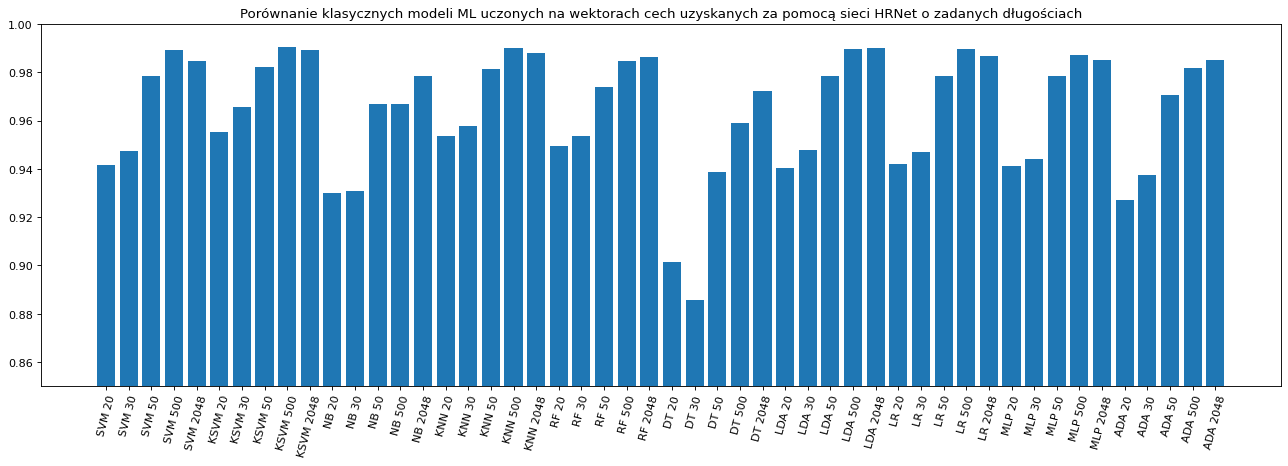

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize = (20,6), dpi=80)
plt.bar(all_names, all_results, width = 0.8)
plt.xticks(rotation = 75) 
plt.title("Porównanie klasycznych modeli ML uczonych na wektorach cech uzyskanych za pomocą sieci HRNet o zadanych długościach")
plt.ylim((0.85,1.0))
plt.show()